CONFIRM CASES


In [ ]:
pip install helper

**importing the important libraries**

In [2]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the datasete**

In [4]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [5]:
q=dataframe.query('Country=="United Kingdom"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     243695
2020-05-18     246406
2020-05-19     248818
2020-05-20     248293
2020-05-21     250908

[121 rows x 1 columns]

**Spilting the dataset**

In [6]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28     161145
2020-04-29     165221
2020-04-30     171253
2020-05-01     177454
2020-05-02     182260
2020-05-03     186599
2020-05-04     190584
2020-05-05     194990
2020-05-06     201101
2020-05-07     206715
2020-05-08     211364
2020-05-09     215260
2020-05-10     219183
2020-05-11     223060
2020-05-12     226463
2020-05-13     229705
2020-05-14     233151
2020-05-15     236711
2020-05-16     240161
2020-05-17     243695
2020-05-18     246406
2020-05-19     248818
2020-05-20     248293
2020-05-21     250908

In [7]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


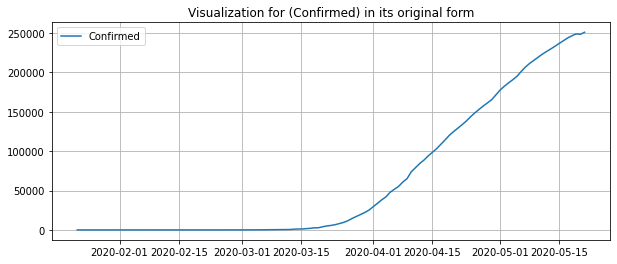

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [9]:
df.tail()

Confirmed
Date                 
2020-05-17     243695
2020-05-18     246406
2020-05-19     248818
2020-05-20     248293
2020-05-21     250908

In [10]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [ ]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     243695
2020-05-18     246406
2020-05-19     248818
2020-05-20     248293
2020-05-21     250908

In [11]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [12]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [13]:
#Mean absolute percentage error (MAPE) 
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [14]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [17]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [18]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 107009.25785650511, 64373.90909090909)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 107009.25785650511, 64373.90909090909)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 85280.32105974112, 73827.58602554469)
([(0, 0, 0), (0, 0, 0, 365), 't'], 51789.831324703344, 45127.230697546416)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 39534.75729158785, 34535.710743801654)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 186612.41678833964, 111493.27383006281)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 45112.22930085009, 37837.715186021145)
([(0, 0, 1), (0, 0, 0, 365), 't'], 26008.013782622198, 22750.94330993987)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 57689.07090006447, 34864.048172357274)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 28209.42435175245, 16928.669283124567)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 1738555.120504858, 1289017.9957280098)
([(0, 0, 2), (0, 0, 0, 365), 't'], 14137.593111538172, 12424.90861622477)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 512228.71796782553, 336899.5425452528)
([(0, 1, 0), (0, 0, 0, 3

In [19]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 0, 1), (0, 0, 0, 365), 'n'] 722.5201396391311 402.7944180159174


In [20]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

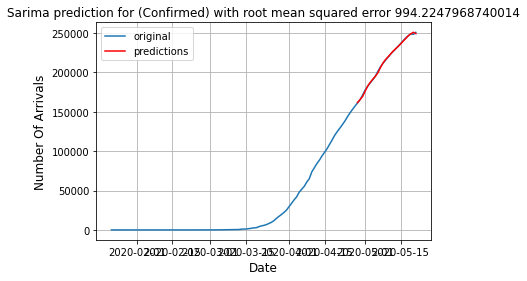

In [21]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [22]:
errors = mape(test, predictions)
errors

15.719388459793587

In [ ]:
Recovered Cases in UK'''

' Recovered Cases in Germany'

RECOVERED CASES

In [25]:
q=dataframe.query('Country=="United Kingdom"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17        458
2020-05-18        475
2020-05-19        479
2020-05-20        492
2020-05-21        508

[121 rows x 1 columns]

**Spliting the dataset**

In [26]:
trainr=dfr[0:97]
testr=dfr[97:]
len(testr)

24

In [27]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


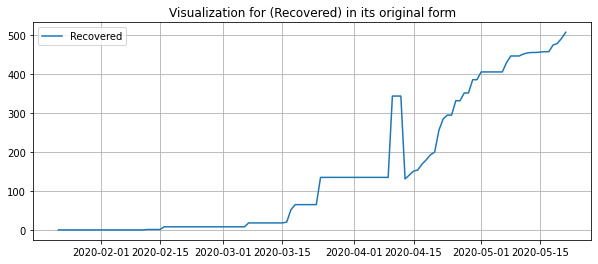

In [28]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [29]:
dfr.tail()

Recovered
Date                 
2020-05-17        458
2020-05-18        475
2020-05-19        479
2020-05-20        492
2020-05-21        508

In [30]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [31]:
df_to_test.tail()

Recovered
Date                 
2020-05-17        458
2020-05-18        475
2020-05-19        479
2020-05-20        492
2020-05-21        508

In [32]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [33]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [34]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [36]:
#finding the best parameters
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [37]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 226.1870432018525, 149.2396694214876)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 226.1870432018525, 149.2396694214876)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 169.4183318183438, 143.44043027819706)
([(0, 0, 0), (0, 0, 0, 365), 't'], 91.03490647739875, 83.33962005972697)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 68.43484876201506, 61.47365012476883)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 126.02160770449258, 82.254090051034)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 99.18779277646021, 86.1655948340967)
([(0, 0, 1), (0, 0, 0, 365), 't'], 58.08372575498131, 49.81010356236502)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 47.85334364059048, 38.78624105233784)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 77.89167542875764, 49.901222580910435)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 65.89142170368345, 55.82062960023884)
([(0, 0, 2), (0, 0, 0, 365), 't'], 36.971799883824, 31.092228706567617)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 35.297799812876335, 26.012379282026664)
([(0, 1, 0), (0, 0, 0, 365), 'n'], 29

In [38]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 1, 2), (0, 0, 0, 365), 'ct'] 25.68399733642874 10.583645834075849


In [39]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

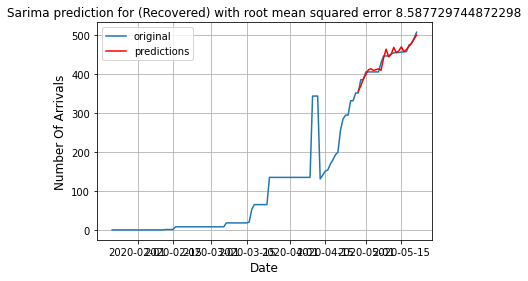

In [40]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [41]:
mape(testr, predictions)

9.802692767908677

In [ ]:
# Deaths cases

DEATH CASES

In [42]:
q=dataframe.query('Country=="United Kingdom"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   34636
2020-05-18   34796
2020-05-19   35341
2020-05-20   35704
2020-05-21   36042

[121 rows x 1 columns]

In [43]:
# Series to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


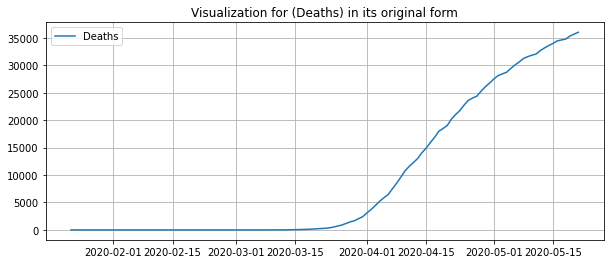

In [44]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [45]:
dfd.tail()

Deaths
Date              
2020-05-17   34636
2020-05-18   34796
2020-05-19   35341
2020-05-20   35704
2020-05-21   36042

In [46]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28   25302
2020-04-29   26097
2020-04-30   26771
2020-05-01   27510
2020-05-02   28131
2020-05-03   28446
2020-05-04   28734
2020-05-05   29427
2020-05-06   30076
2020-05-07   30615
2020-05-08   31241
2020-05-09   31587
2020-05-10   31855
2020-05-11   32065
2020-05-12   32692
2020-05-13   33186
2020-05-14   33614
2020-05-15   33998
2020-05-16   34466
2020-05-17   34636
2020-05-18   34796
2020-05-19   35341
2020-05-20   35704
2020-05-21   36042

In [47]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [48]:
df_to_test.tail()

Deaths
Date              
2020-05-17   34636
2020-05-18   34796
2020-05-19   35341
2020-05-20   35704
2020-05-21   36042

In [49]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [50]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [51]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [52]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [53]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 15836.377299597487, 9439.297520661157)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 15836.377299597487, 9439.297520661157)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 12686.770348063761, 11145.397650433712)
([(0, 0, 0), (0, 0, 0, 365), 't'], 7815.675228564515, 6888.556382039052)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 6023.951500693024, 5298.23137313472)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 8017.928838198385, 4802.581964630456)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 22984.67532124902, 14183.184400343116)
([(0, 0, 1), (0, 0, 0, 365), 't'], 13578.765948394093, 12009.397771561697)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 6935.769976926256, 5941.81754848012)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 4279.163218879354, 2569.8663890877447)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 3848.7330014014283, 3238.236185380397)
([(0, 0, 2), (0, 0, 0, 365), 't'], 8896.389101215515, 7925.264202665997)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 2086.2063476602066, 1626.5030579238692)
([(0, 1, 0), (0, 0, 0, 365), 'n'

In [54]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 0, 2), (0, 0, 0, 365), 't'] 137.96455976881225 88.58323744212343


In [55]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

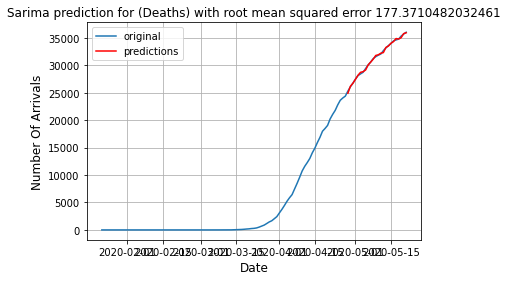

In [56]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [57]:
mape(testd,predictions)

11.820633739383535